In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import os
import datetime as dt
import pickle

from utils import processing
from utils import utils

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, \
    BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import wandb
from wandb.keras import WandbCallback


In [2]:
random.seed(hash("random seed") % 2**32 - 1)
np.random.seed(hash("numpy seed") % 2**32 - 1)
tf.random.set_seed(hash("tensorflow seed") % 2**32 - 1)

In [3]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,12)

In [4]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
kld = kld[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = stb[['Value', 'sunshine_mins', 'airtemp_c', 'daylength_hrs', 'wkdy_sin', 'wkdy_cos', 'wknd', 'mnth_sin', 'mnth_cos']]

In [5]:
# Processing Parameters
steps = 1 # timesteps: 1 hour
num_features = 9

lookback = 744 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 224
epochs = 100
lr = 0.04

In [6]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.ts_offset_split(kld, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.ts_offset_split(stb, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [30]:
def metrics(true, pred):
    print(f'MSE: {np.mean(mean_squared_error(true, pred))}')
    print(f'RMSE: {np.sqrt(np.mean(mean_squared_error(true, pred)))}')
    print(f'MAE: {np.mean(mean_absolute_error(true, pred))}')
    print(f'MAPE: {np.mean(mean_absolute_percentage_error(true, pred))}')

# CNN: Kolding Dataset

In [8]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (224, 744, 9)
Target Shape: (224, 1)


In [9]:
CNN_base_kld = Sequential()
CNN_base_kld.add(Input(shape=(lookback, num_features)))
CNN_base_kld.add(Conv1D(filters=56, kernel_size=3, activation='relu'))
CNN_base_kld.add(MaxPooling1D(pool_size=2))

CNN_base_kld.add(Flatten())

CNN_base_kld.add(Dense(56, activation='relu'))
CNN_base_kld.add(Dense(1))

CNN_base_kld.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

In [10]:
# Callbacks
estp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, verbose=1)

ckpt_path = "../model/models/CNN_benchmark_kld.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [11]:
history_kld = CNN_base_kld.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Epoch 1/100
66/66 [==============================] - 9s 127ms/step - loss: 49212.6866 - mae: 71.7230 - val_loss: 1.1388 - val_mae: 0.7965

Epoch 00001: val_loss improved from inf to 1.13876, saving model to ../model/models\CNN_benchmark_kld.h5
Epoch 2/100
66/66 [==============================] - 7s 103ms/step - loss: 1.0250 - mae: 0.8097 - val_loss: 1.1403 - val_mae: 0.7967

Epoch 00002: val_loss did not improve from 1.13876
Epoch 3/100
66/66 [==============================] - 7s 105ms/step - loss: 1.0323 - mae: 0.8105 - val_loss: 1.1425 - val_mae: 0.7969- ETA: 2s - loss: 1.0413 - m - ETA: 1s - loss: 1.0

Epoch 00003: val_loss did not improve from 1.13876
Epoch 4/100
66/66 [==============================] - 7s 105ms/step - loss: 1.0361 - mae: 0.8121 - val_loss: 1.1450 - val_mae: 0.7972 ETA: 2s - loss: 

Epoch 00004: val_loss did not improve from 1.13876
Epoch 5/100
66/66 [==============================] - 7s 106ms/step - loss: 1.0403 - mae: 0.8112 - val_loss: 1.1478 - val_mae: 0.7975- 

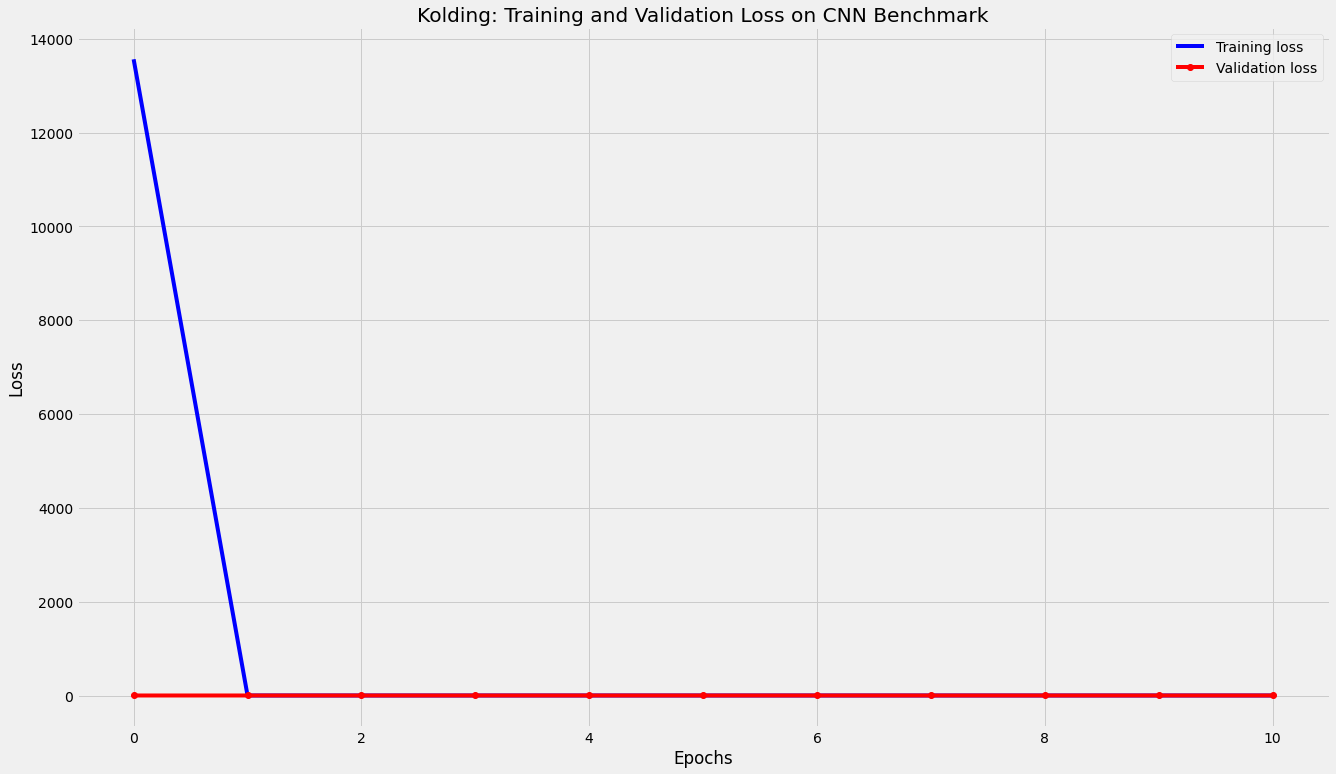

In [12]:
utils.plot_training(history_kld, "Kolding: Training and Validation Loss on CNN Benchmark")

In [12]:
CNN_base_kld.load_weights(ckpt_path)

In [13]:
kld_eval = CNN_base_kld.evaluate(kld_test)

7/7 [==============================] - 1s 82ms/step - loss: 1.4020 - mae: 0.8665


In [14]:
kld_std = 31.31291841
kld_mean = 87.50684772
print(f'Inverse Scaled MAE: {round(kld_eval[1] * kld_std, 2)}')

Inverse Scaled MAE: 27.13


In [15]:
kld_pred = CNN_base_kld.predict(kld_test)
kld_inverse_scaled_pred = (kld_pred * kld_std) + kld_mean


y_true_kld = pd.read_csv('y_true_kolding.csv', index_col='Datetime', parse_dates=['Datetime'])
kld_pred_df = y_true_kld.copy()
kld_pred_df.rename(columns={'Value':'True'}, inplace=True)
kld_pred_df['Pred'] = kld_inverse_scaled_pred

In [32]:
metrics(kld_pred_df['True'].values, kld_pred_df['Pred'].values)

MSE: 1265.09912109375
RMSE: 35.568233489990234
MAE: 26.17221450805664
MAPE: 22.435352325439453


# CNN: Middelfart Dataset

In [19]:
for batch in stb_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (224, 744, 9)
Target Shape: (224, 1)


In [21]:
CNN_base_stb = Sequential()
CNN_base_stb.add(Input(shape=(lookback, num_features)))
CNN_base_stb.add(Conv1D(filters=56, kernel_size=3, activation='relu'))
CNN_base_stb.add(MaxPooling1D(pool_size=2))
CNN_base_stb.add(Flatten())

CNN_base_stb.add(Dense(56, activation='relu'))
CNN_base_stb.add(Dense(1))

CNN_base_stb.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['mae'])

In [23]:
estp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5)

ckpt_path = "../model/models/CNN_benchmark_stb.h5"
ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)


In [24]:
history_stb = CNN_base_stb.fit(
    stb_train,
    epochs=epochs,
    validation_data=stb_val,
    callbacks=[estp, ckpt, reduce_lr]
)

Epoch 1/100
66/66 [==============================] - 8s 108ms/step - loss: 43563.1652 - mae: 59.2313 - val_loss: 1.1109 - val_mae: 0.7947

Epoch 00001: val_loss improved from inf to 1.11090, saving model to ../model/models\CNN_benchmark_stb.h5
Epoch 2/100
66/66 [==============================] - 7s 108ms/step - loss: 1.0223 - mae: 0.8172 - val_loss: 1.1130 - val_mae: 0.7948- mae:

Epoch 00002: val_loss did not improve from 1.11090
Epoch 3/100
66/66 [==============================] - 7s 105ms/step - loss: 1.0192 - mae: 0.8157 - val_loss: 1.1159 - val_mae: 0.7949

Epoch 00003: val_loss did not improve from 1.11090
Epoch 4/100
66/66 [==============================] - 7s 108ms/step - loss: 1.0126 - mae: 0.8111 - val_loss: 1.1193 - val_mae: 0.7950

Epoch 00004: val_loss did not improve from 1.11090
Epoch 5/100
66/66 [==============================] - 7s 106ms/step - loss: 1.0281 - mae: 0.8147 - val_loss: 1.1232 - val_mae: 0.7952

Epoch 00005: val_loss did not improve from 1.11090
Epoch 6/10

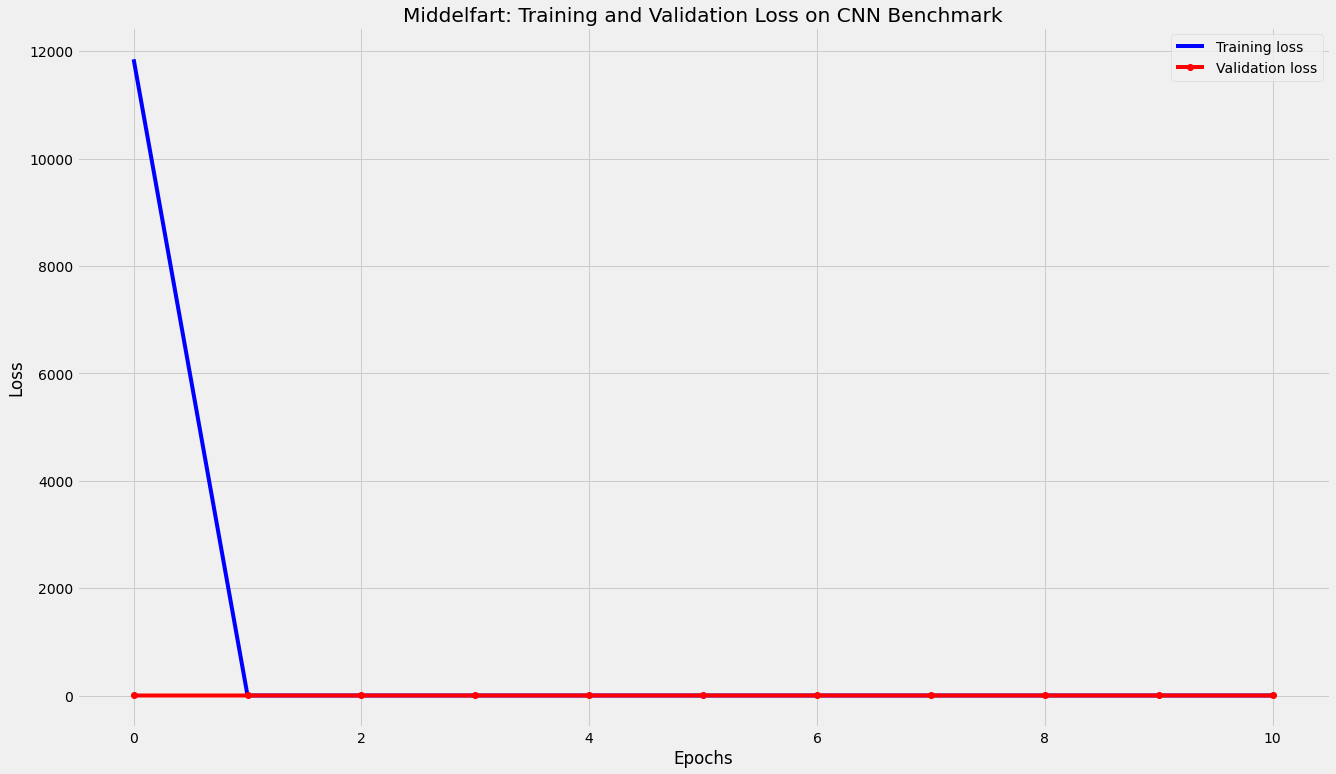

In [29]:
utils.plot_training(history_stb, "Middelfart: Training and Validation Loss on CNN Benchmark")

In [25]:
stb_eval = CNN_base_stb.evaluate(stb_test)

7/7 [==============================] - 0s 38ms/step - loss: 1.3493 - mae: 0.8548


In [26]:
stb_std = 18.33954707
stb_mean = 52.17963965
print(f'Inverse Scaled MAE: {round(stb_eval[1] * stb_std, 2)}')

Inverse Scaled MAE: 15.68


In [27]:
stb_pred = CNN_base_stb.predict(kld_test)
stb_inverse_scaled_pred = (stb_pred * kld_std) + stb_mean


y_true_stb = pd.read_csv('y_true_strib.csv', index_col='Datetime', parse_dates=['Datetime'])
stb_pred_df = y_true_stb.copy()
stb_pred_df.rename(columns={'Value':'True'}, inplace=True)
stb_pred_df['Pred'] = stb_inverse_scaled_pred

In [31]:
metrics(stb_pred_df['True'].values, stb_pred_df['Pred'].values)

MSE: 465.6524353027344
RMSE: 21.578981399536133
MAE: 16.64790916442871
MAPE: 22.158018112182617
